# Coding Discussion 6
### Yousuf Abdelfatah


## Import Packages

In [48]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

## Load the Data

In [49]:
# view training data
train = pd.read_csv("../train_data.csv")
test = pd.read_csv("../test_data.csv")

In [50]:
#show the possible features
list(train)

['OBJECTID',
 'SSL',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STYLE_D',
 'STRUCT',
 'STRUCT_D',
 'GRADE',
 'GRADE_D',
 'CNDTN',
 'CNDTN_D',
 'EXTWALL',
 'EXTWALL_D',
 'ROOF',
 'ROOF_D',
 'INTWALL',
 'INTWALL_D',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'LN_PRICE']

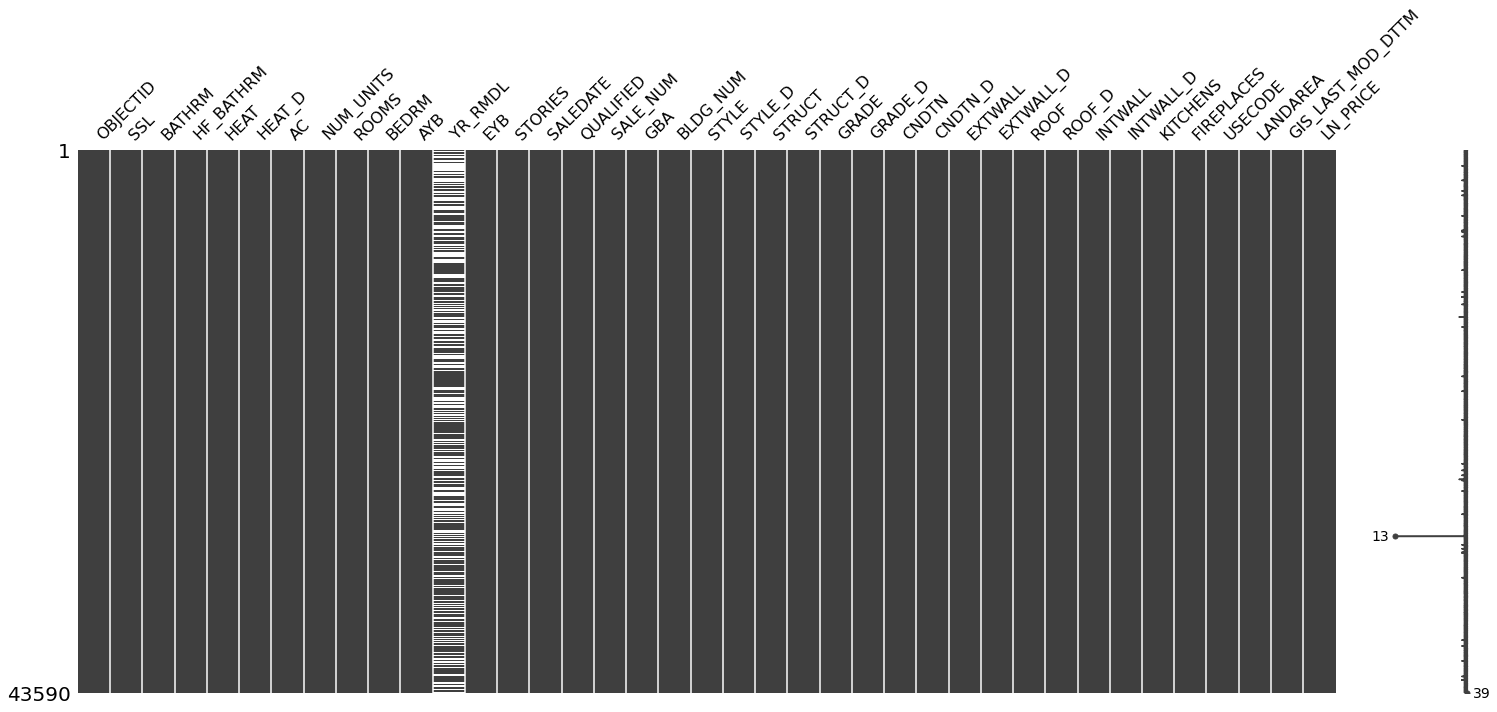

In [51]:
# see if we have missingness in our data
miss.matrix(train)

## Data Cleaning and Pre-processing

In [52]:
# Feature selection
train = train[['LN_PRICE','BATHRM','HF_BATHRM', 'AC', 'NUM_UNITS','ROOMS','BEDRM', 'STORIES','SALEDATE','QUALIFIED','SALE_NUM', 'YR_RMDL','GBA','BLDG_NUM','GRADE','CNDTN','KITCHENS','FIREPLACES', 'LANDAREA']]
test = test[['LN_PRICE','BATHRM','HF_BATHRM', 'AC', 'NUM_UNITS','ROOMS','BEDRM', 'STORIES','SALEDATE','QUALIFIED','SALE_NUM', 'YR_RMDL','GBA','BLDG_NUM','GRADE','CNDTN','KITCHENS','FIREPLACES', 'LANDAREA']]

In [53]:
# log land area
train = train[(train.LANDAREA !=0)]
train["LANDAREA"] = np.log(train["LANDAREA"])
train.rename(columns = {'LANDAREA':'LN_LANDAREA'}, inplace = True) 

# Do the same for test
test = test[(test.LANDAREA !=0)]
test["LANDAREA"] = np.log(test["LANDAREA"])
test.rename(columns = {'LANDAREA':'LN_LANDAREA'}, inplace = True) 

In [54]:
# Make Qualified a dummy- the values are Q (Qualified) and U (Unqualified)
train.QUALIFIED.value_counts(dropna=False)

# create dummy variables
train["QUALIFIED"] = train.QUALIFIED.map({'Q':1,'U':0})

# Do the same for test
test.QUALIFIED.value_counts(dropna=False)
test["QUALIFIED"] = test.QUALIFIED.map({'Q':1,'U':0})

In [55]:
# grade and condition are categorical but they have an order so we're going to change the 0s to NAs
train.GRADE = train.GRADE.replace(0,np.nan)
train.CNDTN = train.CNDTN.replace(0,np.nan)

# repeat for test
test.GRADE = test.GRADE.replace(0,np.nan)
test.CNDTN = test.CNDTN.replace(0,np.nan)

In [56]:
# replace the current 0 value for AC with nan since no AC is already marked by N
train.replace(to_replace={'AC':'0'},value={'AC':np.nan}, inplace=True)

test.replace(to_replace={'AC':'0'},value={'AC':np.nan}, inplace=True)

In [57]:
# turn AC into a dummy variable
AC_dummy = pd.get_dummies(train.AC, prefix="AC", drop_first=True)

AC_dummy2 = pd.get_dummies(test.AC, prefix="AC", drop_first=True)

In [58]:
# drop the current AC variable and add the dummy variable we created
train.drop("AC", axis = 1, inplace=True)
train = pd.concat([train, AC_dummy], axis = 1)

test.drop("AC", axis = 1, inplace=True)
test = pd.concat([test, AC_dummy2], axis = 1)

In [59]:
# Extract the year from SALEDATE and make it numeric
train.SALEDATE = train.SALEDATE.str.split("-").str[0].astype(int)

test.SALEDATE = test.SALEDATE.str.split("-").str[0].astype(int)

In [60]:
# if year remodeled is NA we're just going to assume it wasn't remodeled. To make this work for us we'll treat remodeled as a categorical variable- if it has a value we'll make it 1 and if it was never remodeled we'll make it a 0
train['RMDL'] = np.where(train.YR_RMDL.isnull(), 0, 1)
train.drop("YR_RMDL", axis = 1, inplace = True)

test['RMDL'] = np.where(test.YR_RMDL.isnull(), 0, 1)
test.drop("YR_RMDL", axis = 1, inplace = True)

In [61]:
# finally drop NAs
train.dropna(inplace=True)

test.dropna(inplace=True)

In [62]:
#split so we can use SKLearn
train_x = train[['BATHRM','HF_BATHRM', 'AC_Y', 'NUM_UNITS','ROOMS','BEDRM', 'STORIES','SALEDATE','QUALIFIED','SALE_NUM', 'RMDL','GBA','BLDG_NUM','GRADE','CNDTN','KITCHENS','FIREPLACES','LN_LANDAREA']]
train_y = train[["LN_PRICE"]]
test_x = train[['BATHRM','HF_BATHRM', 'AC_Y', 'NUM_UNITS','ROOMS','BEDRM', 'STORIES','SALEDATE','QUALIFIED','SALE_NUM', 'RMDL','GBA','BLDG_NUM','GRADE','CNDTN','KITCHENS','FIREPLACES','LN_LANDAREA']]
test_y = train[["LN_PRICE"]]

In [63]:
# scale
scaler = pp.MinMaxScaler ()
col_names = list(train_x)
train_x = scaler.fit_transform(train_x)

# Convert back into data frame
train_x = pd.DataFrame(train_x,columns=col_names)

# scale test
scaler = pp.MinMaxScaler ()
col_names = list(test_x)
test_x = scaler.fit_transform(test_x)

# Convert back into data frame
test_x = pd.DataFrame(test_x,columns=col_names)

## Try the various models

In [64]:
# In order to make valid comparisons we need to use the same data splits for each fold. To do this we need to create a K-fold generator
fold_generator = KFold(n_splits=5, shuffle=True, random_state=134)

In [65]:
# Mean Squared Error will be our perfomance metrix
use_metrics = ["neg_mean_squared_error"]

In [66]:
# Linear Model
lm_scores = cross_validate(LM(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

In [67]:
#KNN
knn_scores = cross_validate(KNN(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

In [68]:
#Decision Tree
dt_scores = cross_validate(DTree(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

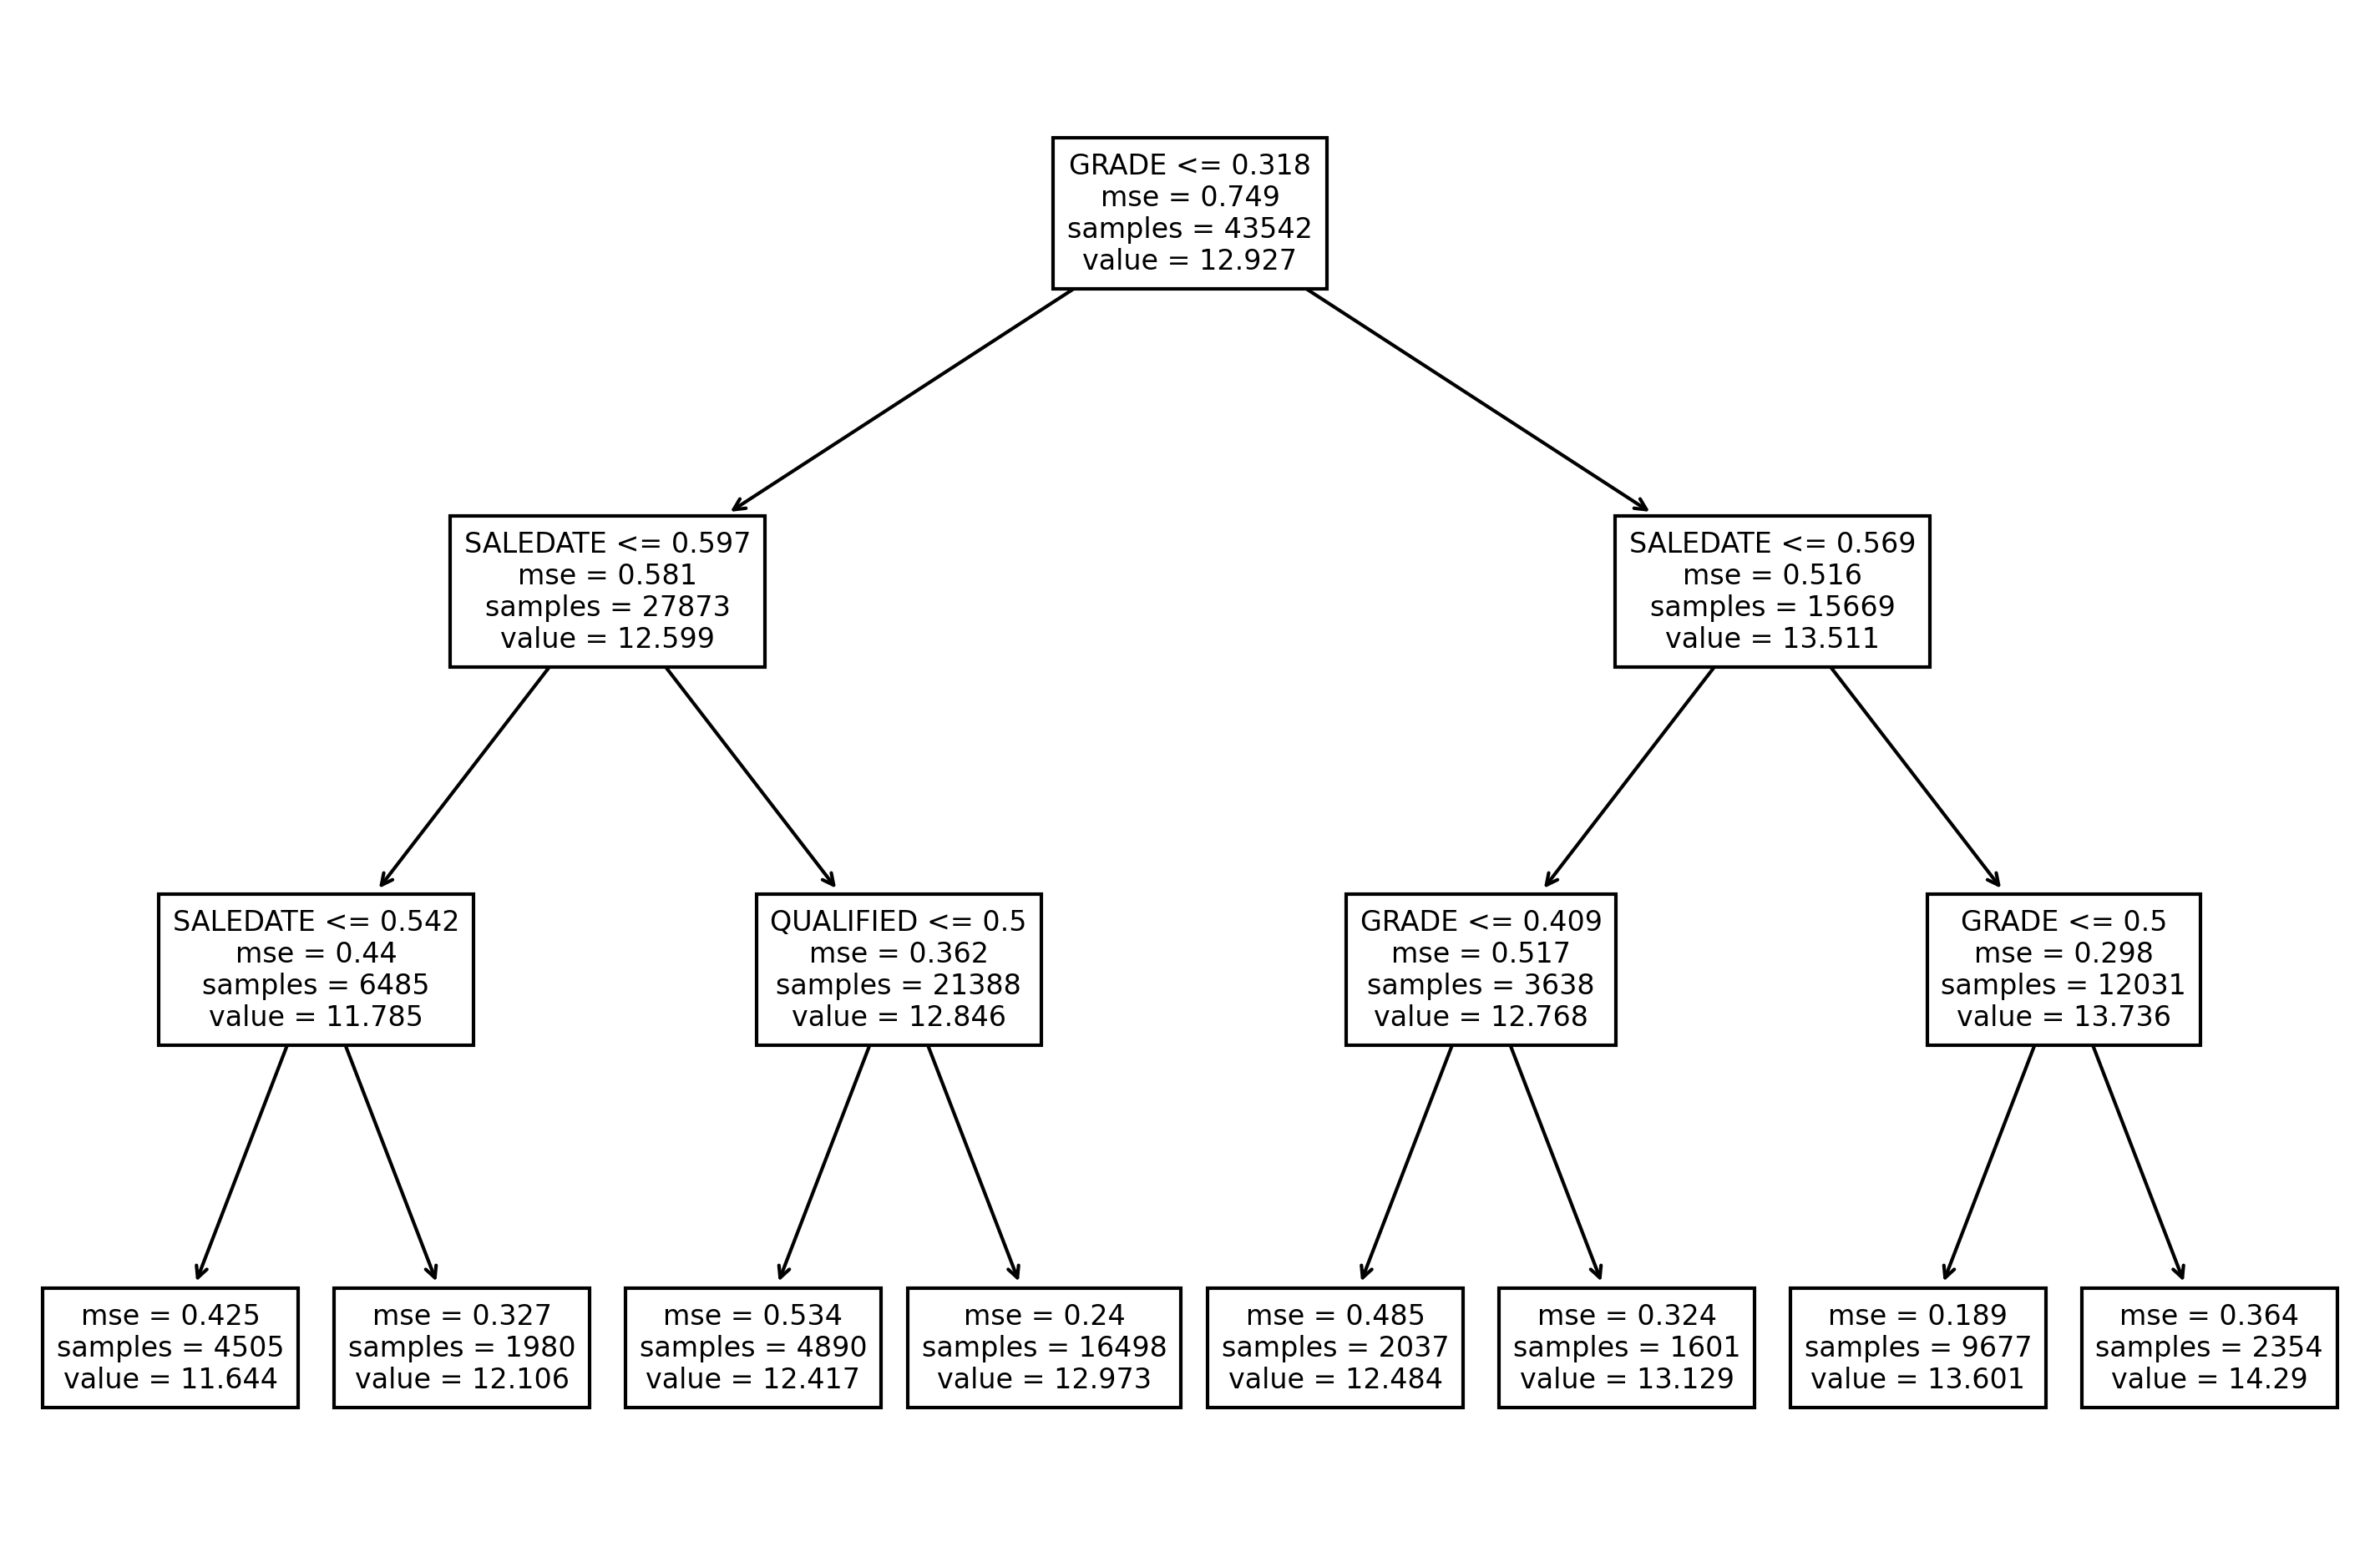

In [69]:
# Show the decision tree

mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_x,train_y) # Fit the mode

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=8)

In [70]:
#bagging
bag_scores = cross_validate(Bag(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

In [71]:
#random forest
rf_scores = cross_validate(RF(),train_x,train_y, cv = fold_generator, scoring =use_metrics)

### Compare models

In [72]:
# Collect all the metrics we care about as a dictionary 
collect_scores = dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.204835
1,lm,0.219653
2,lm,0.233341
3,lm,0.198816
4,lm,0.229907
5,knn,0.185338
6,knn,0.205574
7,knn,0.217939
8,knn,0.184603
9,knn,0.210502


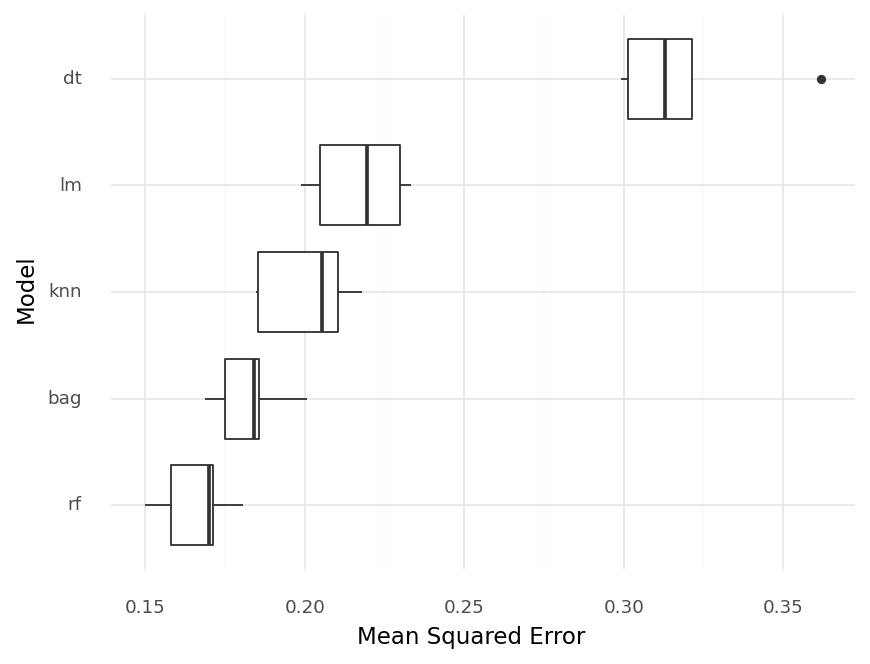

<ggplot: (310010609)>

In [73]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

It looks like the best model here was the random forest since it has the lowest squared error. Unsurprisingly, the worst model by a significant margin was the decision tree

## Tuning Hyper Parameters


In [74]:
# Parameters for KNN
mod = KNN()
mod.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [75]:
# we'll tune the nearest neighbor parameter using a grid search
#first we specift the possible values
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

In [76]:
# then use gridsearch to tune
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error')

In [77]:
# then use.fit() on the model
tune_knn.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=134, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_mean_squared_error')

In [78]:
# the best parameters are
tune_knn.best_params_

{'n_neighbors': 10}

In [79]:
# we'll do the same for the other models
# first for the decision tree. We'll tune max depth
DTree().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [80]:
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error')

In [81]:
tune_dt.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=134, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [82]:
tune_dt.best_params_

{'max_depth': 8}

In [83]:
# for the random forest we'll tune max depth and n estimators
RF().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [88]:
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000]} 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error')

In [89]:
tune_rf.fit(train_x,train_y) 

GridSearchCV(cv=KFold(n_splits=5, random_state=134, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [90]:
tune_rf.best_params_

{'max_depth': 3, 'n_estimators': 1000}

In [91]:
# rerun these three models with the now tuned parameters and see if there were improvements

In [92]:
#KNN
knn_scores = cross_validate(KNN(n_neighbors = 10),train_x,train_y, cv = fold_generator, scoring =use_metrics)

In [93]:
# Decision Tree
dt_scores = cross_validate(DTree(max_depth=8),train_x,train_y, cv = fold_generator, scoring =use_metrics)

In [95]:
rf_scores = cross_validate(RF(max_depth =3, n_estimators = 1000),train_x,train_y, cv = fold_generator, scoring =use_metrics)

In [96]:
# Collect all the metrics we care about as a dictionary 
collect_scores = dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,0.204835
1,lm,0.219653
2,lm,0.233341
3,lm,0.198816
4,lm,0.229907
5,knn,0.175603
6,knn,0.191579
7,knn,0.206984
8,knn,0.171598
9,knn,0.199510


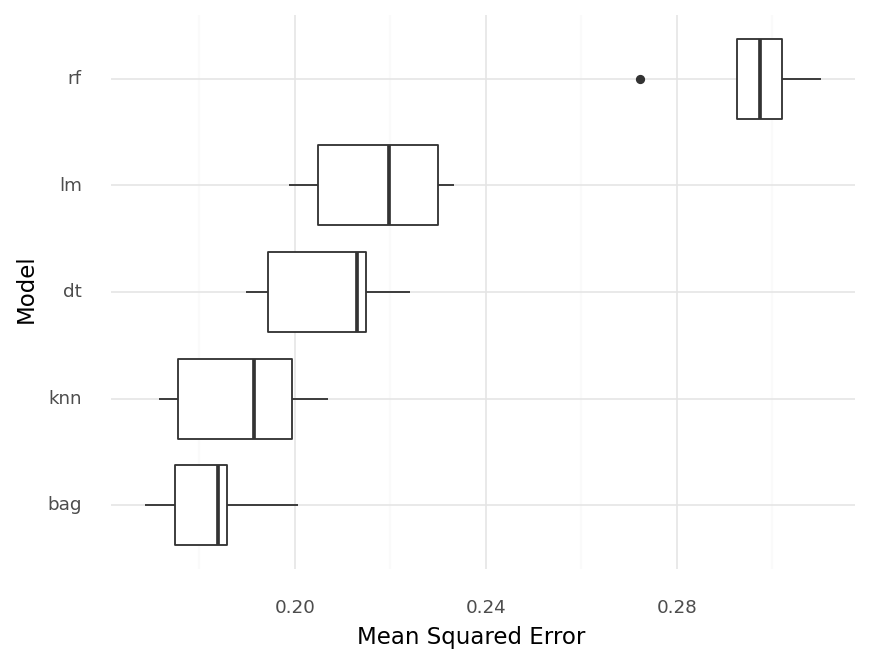

<ggplot: (307536517)>

In [97]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

For some reason the random forest got worse when we tuned the paramters, probably because the estimators that were determined automatically were better then the options we put in. I would play with the parameters more but the rf model takes a long time to load so for the purposes of this coding discussion I'll move on. The other models all improved, and bagging is now the model with the lowest MSE

## Use a pipeline

In [99]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('model', None)]), n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [1, 2, 3, 5]},
                         {'model': [BaggingRegressor()]},
                         {'model': [RandomForestRegressor()],
                          'model__max_depth': [1, 2, 3],
                          'model__n_estimators': [500, 1000, 1250]}],
             scoring='neg_mean_squared_error')

In [100]:
# what was the best score with the pipeline
search.best_score_

-0.18115542267015297

In [101]:
# See which model worked the best
search.best_params_

{'model': BaggingRegressor()}

In [102]:
## Test the model on the Test Data

In [103]:
# the predict method will automatically use the best model
pred_y = search.predict(test_x)

In [104]:
# Calculate the mean squared error
print("The mean squared error is", m.mean_squared_error(test_y,pred_y))

The mean squared error is 0.031872218644649467
